## 145. BERT Fine-Tuning Tutorial with HuggingFace PyTorch Library

- [Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) tutorial 을 기초로 작성함

In [1]:
import torch
import transformers
import wget

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

- Hugging Face Library 설치
    - !pip install transformers

## Loading CoLA Dataset

- 단일 문장 분류를 위해 [CoLA (Corpus of Linguistic Acceptability)](https://nyu-mll.github.io/CoLA/) 데이터 세트를 사용  
- 문법적으로 정확하거나 틀린 것으로 표시된 문장 세트   
- ```GLUE Benchmark```에 포함 된 테스트 중 하나

### Download & Extract

dataset 은 GitHub 에서 repo 가능: https://nyu-mll.github.io/CoLA/

In [2]:
import wget
import os

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

if not os.path.exists('./cola_public'):
    !unzip cola_public_1.1.zip

## 2.2. Parse

파일 이름에서 `tokenized` 및 `raw` 버전의 데이터를 모두 사용할 수 있음을 알 수 있습니다.

**pre-trained BERT 를 적용하려면 BERT 모델에서 제공하는 tokenizer 를 사용해야하므로 `tokenized` version 의 data 는 사용할 수 없습니다.** 이는, 


(1) BERT 모델에 특정한 고정 어휘가 있고, 


(2) BERT tokenizer 가 out-of-vocabulary word 를 처리하는 특정 방법을 가지고 있기 때문입니다.

In [3]:
import numpy as np
import pandas as pd

df_train = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None,
                             names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_test = pd.read_csv("./cola_public/raw/in_domain_dev.tsv", delimiter='\t', header=None,
                             names=['sentence_source', 'label', 'label_notes', 'sentence'])
print(df_train.shape)
print(df_test.shape)

(8551, 4)
(527, 4)


- label 
    - 1 : 문법적으로 correct
    - 0 : 문법적으로 incorrect 

In [4]:
df_train.sample(5)

,sentence_source,label,label_notes,sentence
8126,ad03,0,*,Jason intended for PRO to learn magic.
6437,d_98,0,*,Any pilot on duty today must be flying this pl...
3187,l-93,0,*,Her stepmother always clad her in black.
2805,l-93,1,NaN,The stick hit the fence.
1573,r-67,0,*,He'll bring me one if he sees a hot dog.


In [5]:
# 문법적으로 not acceptable
df_train[df_train['label'] == 0].sample(3)[['sentence', 'label']]

,sentence,label
1758,I have some papers to announce that I've got t...,0
5615,Who do you think that saw Bill?,0
1138,"We elected my father, who had just turned 60, ...",0


In [6]:
# 문법적으로 acceptable
df_train[df_train['label'] == 1].sample(5)[['sentence', 'label']]

,sentence,label
8127,The boys should could all go,1
3964,Fred hired Sharon to change the oil.,1
2750,Carmen obtained a spare part from Diana.,1
4906,That John was elected surprised Frank.,1
5735,He turned off the light.,1


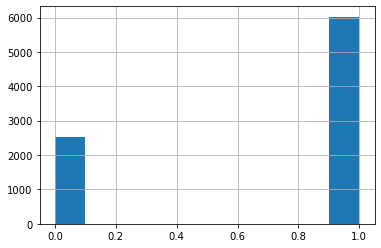

In [7]:
df_train['label'].hist()

- 훈련 세트의 문장과 레이블을 numpy ndarrays로 추출

In [8]:
train_sentences = df_train.sentence.values
train_labels = df_train.label.values

test_sentences = df_test.sentence.values
test_labels = df_test.label.values

# 3. Tokenization & Input Formatting

- 데이터 세트를 BERT가 학습 할 수있는 형식으로 변환
    - 토큰으로 분할한 다음 tokenizer vocabulary에서 해당 토큰을 색인에 매핑
    - BERT에 포함 된 토크나이저에 의해 수행되어야 함
    - bert-base-uncased : BERT 기본 size, 소문자 변환된 vocabulary를 가진 모델
    
## BERT 의 formatting requirement

1. 각 문장의 시작과 끝에 특별한 토큰([CLS]와 [SEP])을 추가 
2. 모든 문장을 하나의 일정한 길이로 padding 하거나 truncate  
3. "attetion mask"를 사용하여 real token 과 padding token 을 명시 적으로 구별

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### BERT tokenizer methods 

- tokenizer.tokenize : token 화
- tokenizer.convert_tokens_to_ids : token을 id에 mapping  

실제로는 모든 문장을 변환 할 때,`tokenize`와`convert_tokens_to_ids`를 별도로 호출하지 않고`tokenize.encode` 함수를 사용하여 두 단계를 모두 처리
- tokenizer.encode 
    - tokenizer.tokenize + 
    - special token([CLS]와 [SEP]) 추가 + 
    - tokenizer.convert_tokens_to_ids +
    - 모든 sentence를 same length로 truncate  
    
    
- tokenizer.encode_plus 
    - tokenizer.encode +
    - real token과 [PAD] token을 구분하는 attention mask 생성

In [10]:
# Print the original sentence.
print(' Original: ', train_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [11]:
print(tokenizer.encode(train_sentences[0], max_length=100))

[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


- encoding용 helper function

In [12]:
def encoding(sentences):
    input_ids = []
    
    for sent in sentences:
        encoded_sent = tokenizer.encode(sent, add_special_tokens=True)
        input_ids.append(encoded_sent)
        
    return input_ids

In [13]:
train_ids = encoding(train_sentences)
test_ids =  encoding(test_sentences)

print('문장길이', len(train_ids))
print('원문장', train_sentences[0])
print('ENCODING 문장', train_ids[0])
print('DECODED 문장', tokenizer.decode(train_ids[0]))

문장길이 8551
원문장 Our friends won't buy this analysis, let alone the next one we propose.
ENCODING 문장 [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]
DECODED 문장 [CLS] our friends won't buy this analysis, let alone the next one we propose. [SEP]


### Padding & Truncating

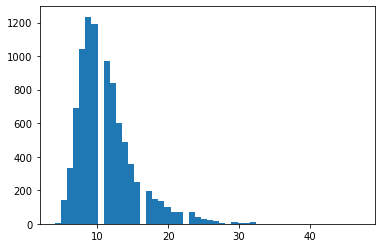

In [14]:
import matplotlib.pyplot as plt

plt.hist([len(sent) for sent in train_ids] + [len(sent) for sent in test_ids], bins=50)
None

MAX_LEN = 32를 선택하고 패딩을 적용

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 32
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

train_sequences = pad_sequences(train_ids, maxlen=MAX_LEN, truncating='post', padding='post')
test_sequences = pad_sequences(test_ids, maxlen=MAX_LEN, truncating='post', padding='post')

print(train_sequences[0])
print(test_sequences[0])


Padding token: "[PAD]", ID: 0
[  101  2256  2814  2180  1005  1056  4965  2023  4106  1010  2292  2894
  1996  2279  2028  2057 16599  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[  101  1996 11279  8469  1996  9478  3154  1997  1996  5749  1012   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


### Attention Masks 생성

BERT vocabulary 는 ID 0 을 사용하지 않으므로 토큰 ID가 0 이면 padding 이고 그렇지 않으면 실제 토큰입니다.

In [16]:
def masking(sequences):
    attention_masks = []
    
    for sent in sequences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [18]:
train_masks = masking(train_sequences)
test_masks = masking(test_sequences)

print(train_masks[0])
print(test_masks[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Converting to PyTorch Data Types

In [19]:
train_sequences = torch.tensor(train_sequences, dtype=torch.long)
test_sequences  = torch.tensor(test_sequences, dtype=torch.long)

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

train_masks  = torch.tensor(train_masks, dtype=torch.long)
test_masks  = torch.tensor(test_masks, dtype=torch.long)

- torch DataLoader 클래스를 사용하여 Dataset에 대한 iterator를 만듭니다. 

- 특정 task 에서 BERT를 fine-tuning 할 때 배치 크기가 16 또는 32 로 하라고 recommend 하고 있습니다.

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# training set 에 대한 DataLoader 생성
train_data = TensorDataset(train_sequences, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

# validation set 에 대한 DataLoader 생성
test_data = TensorDataset(test_sequences, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# BERT Fine-tuning

입력 데이터가 올바르게 포맷 되었으므로 BERT를 미세 조정할 때입니다.

## 4.1. BertForSequenceClassification

fine-tuning 을 위해 제공되는 현재의 class list:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification 
* BertForTokenClassification
* BertForQuestionAnswering

우리가 사용할 것은 [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification)입니다.  

- sentence classifier 로 사용할 분류를 위한 단일 linear layer가 추가 된 통상적 BERT 모델  

- 사전 훈련된 전체 BERT 모델과 추가된 훈련되지 않은 classification layer 가 특정 task 에 대해 훈련된다.

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2,   # binary,  >= 3 multi-class task
    output_attentions=False,        # model 이 attention weights 를 반환할지 여부
    output_hidden_states=False)     # model 이 모든 hidden-state 를 반환할지 여부

model.to(device)
None

참고삼아 아래의 names, dimensions of the weights 출력.

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

- fine-tuning 에 다음 값들이 recommend 됩니다. 
    - 배치 크기 : 16, 32 (DataLoader 를 만들 때 32 를 선택).
    - Learning rate(Adam) : 5e-5, 3e-5, 2e-5 (2e-5 사용)
    - 에포크 수 : 2, 3, 4 (4를 사용).

- The epsilon parameter `eps = 1e-8` zero divide 방지를 위한 매우 작은 숫자임. (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

- AdamW(Adam algorithm with weight decay fix) optimizer 는 다음 참조 `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [23]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

- get_linear_schedule_with_warmup  

    - 학습률이 워밍업 기간 동안 선형적으로 증가한 이후에 선형적으로 감소

In [24]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                num_warmup_steps=0,  # Default value in run_glue.py
                                num_training_steps=total_steps)

1072


## 4.3. Training Loop

경과시간 formatting 을 위한 helper function.


In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

- model.eval() : 모든 layer 가 eval mode 로 동작. batchnorm, dropout layers 가 training mode 아닌 eval mode 로 동작.
- torch.no_grad() : autograd engine 을 deactivate 하여 memory 절약 및 speed 향상.

In [26]:
import random

seed_val = 42

random.seed(42)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs): 
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    st = time.time()
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - st)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'
                        .format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, # sentence 구분 [0,0,0,0,1,1,1,1]
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple (loss, logits, hidden_states, attentions)
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # training data 의 평균 loss 계산
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # learning curve 시각화를 위해 loss value 저장.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - st)))
        
    # ========================================
    #               Validation
    # ========================================
    # 각 training epoch 이 끝나면, Test set 에 대한 performance 측정.

    print("")
    print("Running Validation...")

    st = time.time()

    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
            
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        label_ids = b_labels.cpu().numpy()
        
        _, y_pred = torch.max(logits, axis=1)
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = sum(y_pred.cpu().numpy() == label_ids) / len(label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - st)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


C:\Users\trimu\Miniconda3\envs\tf20\lib\site-packages\transformers\optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch    40  of    268.    Elapsed: 0:00:31.
  Batch    80  of    268.    Elapsed: 0:01:02.
  Batch   120  of    268.    Elapsed: 0:01:33.
  Batch   160  of    268.    Elapsed: 0:02:04.
  Batch   200  of    268.    Elapsed: 0:02:35.
  Batch   240  of    268.    Elapsed: 0:03:06.

  Average training loss: 0.51
  Training epcoh took: 0:03:28

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:31.
  Batch    80  of    268.    Elapsed: 0:01:02.
  Batch   120  of    268.    Elapsed: 0:01:33.
  Batch   160  of    268.    Elapsed: 0:02:04.
  Batch   200  of    268.    Elapsed: 0:02:36.
  Batch   240  of    268.    Elapsed: 0:03:07.

  Average training loss: 0.33
  Training epcoh took: 0:03:28

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:31.
  Batch    80  of    268.    Elapsed: 0:01:02

### 전체 batch 에 대한 training loss 를 시각화

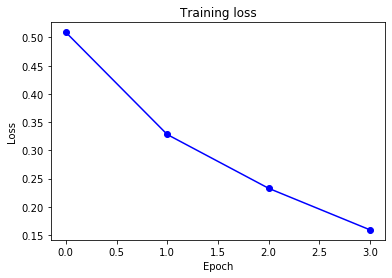

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()